## Tarea 1 - Beer Clustering
### Reconocimiento de patrones en Minería de Datos

Para esta tarea se realizara la implementación de los algoritmos de clustering: *K-means, Minibatch K-means, HAC Complete,Ward y DBSCAN* para el análisis de las reseñas obtenidos de la página beeradvocate la cual consta de un poco más de un millón y medio de datos como el dataset de prueba de los algoritmos, en los cuales se estudiará los valores de entrada de cada uno para obtener los clusters más adecuados.

# Caracterización del dataset
El data set consta de 13 atributos los cuales son:

<table class="tg">
  <tr>
    <th class="tg-yw4l">Nombre atributo</th>
    <th class="tg-yw4l">Tipo<br></th>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_id</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_name</td>
    <td class="tg-yw4l">object</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_time</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_overall</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_aroma</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_appearance</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_profilename</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_style</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_palate</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_taste</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_name</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_abv</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_beerid</td>
    <td class="tg-yw4l">int64</td>
  </tr>
</table>


De los cuales los pares beer_name y beer_beerid con brewery_id y brewery_name son equivalentes entre si y son del tipo de atributo que sirven para etiquetar. Con lo que la dimensión real del dataset puede ser reducida a 11 atributos que son representativo en aspectos de calificativos, temporales y la tendencia de quien lo calificó.


***Arreglar:***
¿Lo que implica que para los algoritmos [K-means, MiniBatch K-means] que funcionan directamente sobre datos categoricos, por varias razones, el espacio muestral de los datos categoricos es discreto, y no tiene un origen natural. La función de distancia Euclidiana en este espacio no tiene un significado de peso. Dicho esto para realizar los cluster en el caso de [k means] se descartarán estos datos de tipo categorico en el análisis.?


Antes de aplicar los algoritmos de clustering, se hace un preprocesamiento de los datos.En esta tarea se guarda un arreglo con 5000 reseñas, se trabaja con este número ya que es el que mejor trabaja en todos los algoritmos(" mínimo común múltiplo") y en otros casos, por limitaciones de los recursos computacionales, aparecen errores de memoria en la ejecución por la gran cantidad de datos.



In [6]:
import numpy as np
import pandas as pn
import scipy
from sklearn import manifold
import matplotlib.pyplot as plt
import sklearn
beer_reviews  = pn.read_csv('beer_reviews/beer_reviews.csv',na_values=[''])
beer_reviews = beer_reviews.sample(n=5000)
beer_reviews = beer_reviews.fillna(method='ffill')
print (beer_reviews.shape)

(5000, 13)


Para la visualización de los clusters, no se toman en cuenta los atributos cuyo valor sean categóricos. Además se realiza una reducción de dimensionalidad de los datos mediante PCA para una visualización en 2D:

In [7]:
from sklearn import preprocessing
from sklearn import decomposition

beer_rev=beer_reviews[['review_overall','review_aroma','review_appearance','review_palate','review_taste','beer_abv']]
#beer_rev = beer_reviews[['brewery_id','review_overall']]

#estandarización de los datos
beer_r = beer_rev.copy()
beer_r['review_overall'] = preprocessing.scale(beer_r['review_overall'].astype(np.float64))
beer_r['review_aroma'] = preprocessing.scale(beer_r['review_aroma'].astype(np.float))
beer_r['review_appearance'] = preprocessing.scale(beer_r['review_appearance'].astype(np.float))
beer_r['review_palate'] = preprocessing.scale(beer_r['review_palate'].astype(np.float))
beer_r['review_taste'] = preprocessing.scale(beer_r['review_taste'].astype(np.float))
beer_r['beer_abv'] = preprocessing.scale(beer_r['beer_abv'].astype(np.float))
#beer_r['brewery_id'] = preprocessing.scale(beer_r['brewery_id'].astype(np.float64))
pca = decomposition.PCA()
pca.n_components = 2
beer_red = pca.fit_transform(beer_r)

Elección de parametros para kmeans, ver:
    
    
http://stats.stackexchange.com/questions/9850/how-to-plot-data-output-of-clustering

**K-Means**:K-Means es un método de clustering que tiene como objetivo particionar n mediciones de un conjunto en k grupos en la que cada observación pertenece al grupo cuyo centroide es más cercano dentro de la distribución de los datos.La dificultad de este algoritmo es que como parámetro se le entrega el número de clusters 'K', pero a priori no se sabe la distribución de los datos y si este 'K' es el óptimo.

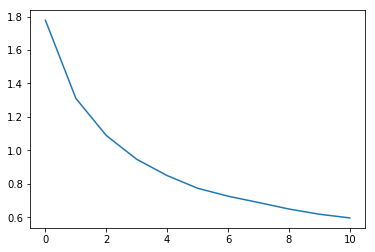

In [8]:
from scipy import cluster 
from sklearn.cluster import KMeans

#Elección Parámetro
initial = [cluster.vq.kmeans(beer_red,i) for i in range(1,12)]
plt.plot([var for (cent,var) in initial])
plt.show()


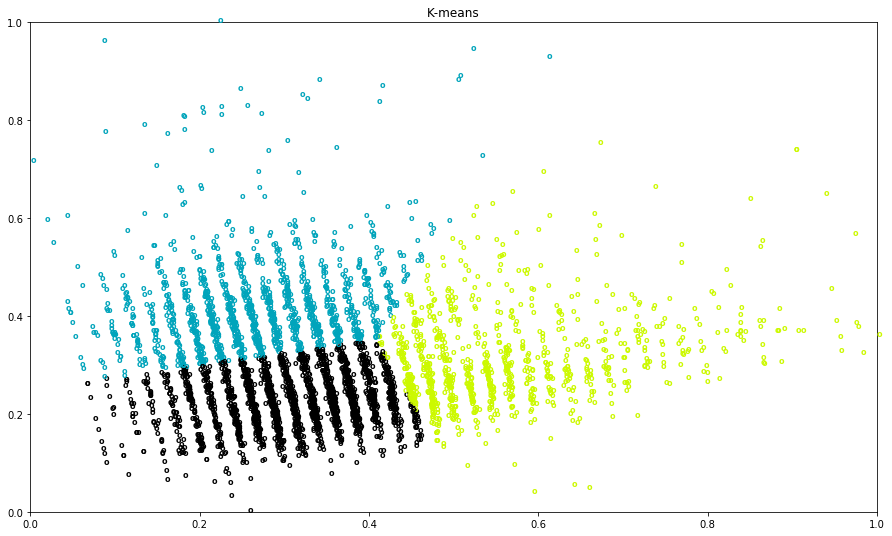

In [9]:

#Normalización para visualización con MDS:
x_min, x_max = np.min(beer_red, axis=0), np.max(beer_red, axis=0)
beer_red = (beer_red - x_min)/(x_max - x_min)
n_samples = beer_red.shape[0]
kmeans = KMeans(init='k-means++',n_clusters=3)
kmeans.fit(beer_red)
#Visualización
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
    plt.text(beer_red[i,0], beer_red[i,1],'o',
    color=plt.cm.spectral(kmeans.labels_[i]/3),
    fontdict={'weight': 'bold', 'size': 8})

plt.title("K-means")
plt.show()


**Minibatch K-MEANS**:

Es una variación del algoritmo de K-means que  usa pequeños lotes "mini-batches" de datos para correr k-means cuando la colección de datos es muy grande, busca escalar a K-Means. Se prefijan los tamaños de los batch y a la hora de recalcular los centroides se utilizan estos en vez de todo el dataset.

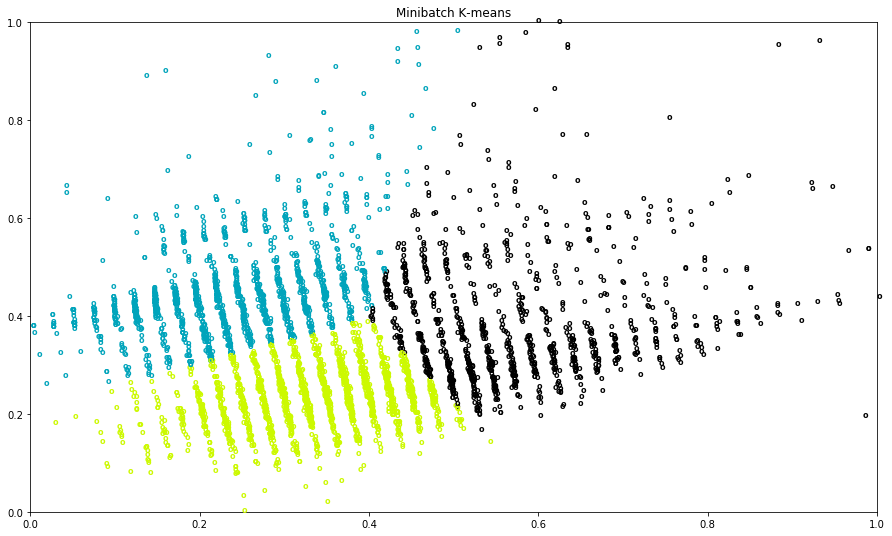

In [4]:
from sklearn.cluster import MiniBatchKMeans

mini_kmeans = MiniBatchKMeans(init='k-means++',batch_size=50,n_clusters=3)
mini_kmeans.fit(beer_red)

x_min, x_max = np.min(beer_red, axis=0), np.max(beer_red, axis=0)
beer_red = (beer_red - x_min)/(x_max - x_min)
n_samples = beer_red.shape[0]

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
    plt.text(beer_red[i,0], beer_red[i,1],'o',
    color=plt.cm.spectral(mini_kmeans.labels_[i]/3),
    fontdict={'weight': 'bold', 'size': 8})

plt.title("Minibatch K-means")
plt.show()


**HAC Complete**
Hierarchical Agglomerative Clustering, es un tipo de clustering 'glotón',parte de un cluster de un punto de tamaño y mediante un criterio de unión definido de distancia se va aglomerando a otro punto formando un cluster de tamaño 2, luego este cluster agrega a otro y así sucesivamente.Este HAC es *Complete*, en este criterio, se aglomeran los clusters done máxima sea su distancia. Esto sigue una estructura jerárquica, dado que a cada unión se crea un cluster compuesto de muchos otros,para visualizar de mejor manera este principio se crea un dendrograma: 

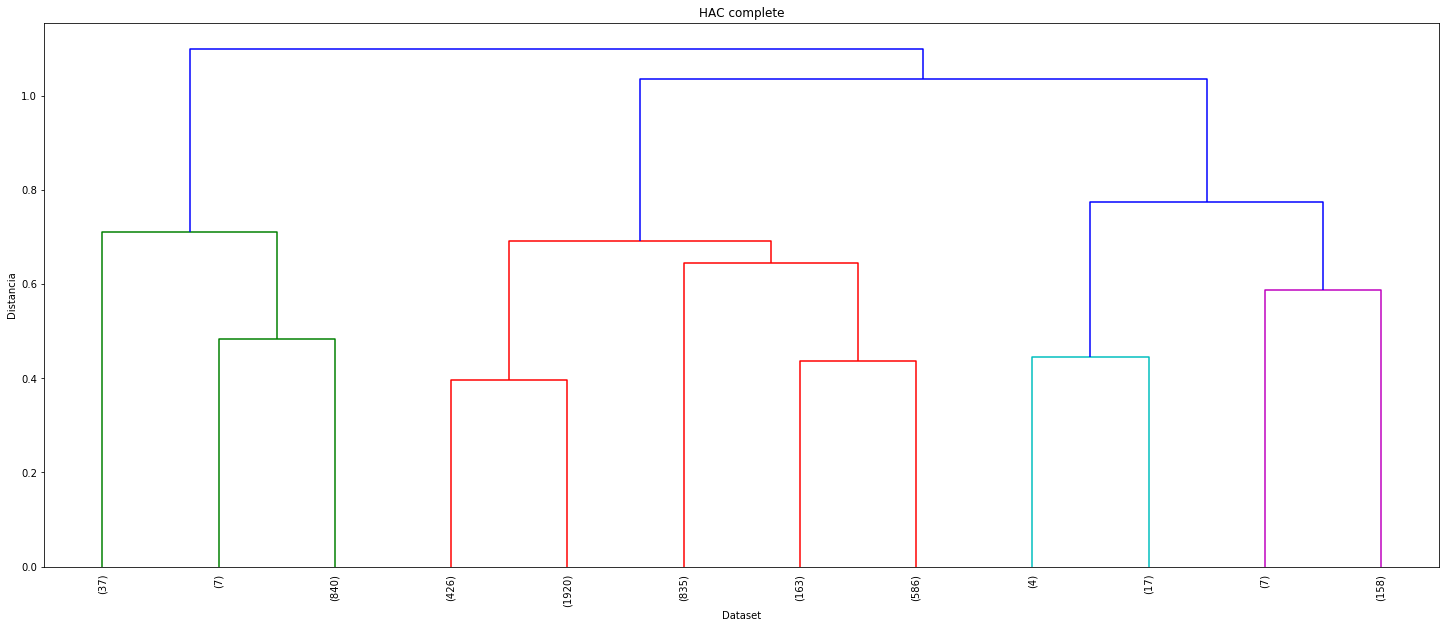

In [10]:
from scipy.cluster.hierarchy import dendrogram,linkage
#matplotlib inline np.set_printoptions(precision=5, suppress=True)
#plt.scatter(beer_red[:,0], beer_red[:,1])
#plt.show()
Z = linkage(beer_red,'complete')
#Visualización en dendrograma
plt.figure(figsize=(25, 10))
plt.title('HAC complete')
plt.xlabel('Dataset')
plt.ylabel('Distancia')
dendrogram(
    Z,
    truncate_mode='lastp',  # Muestra las últimas 'p' uniones
    p=12,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)
plt.show()

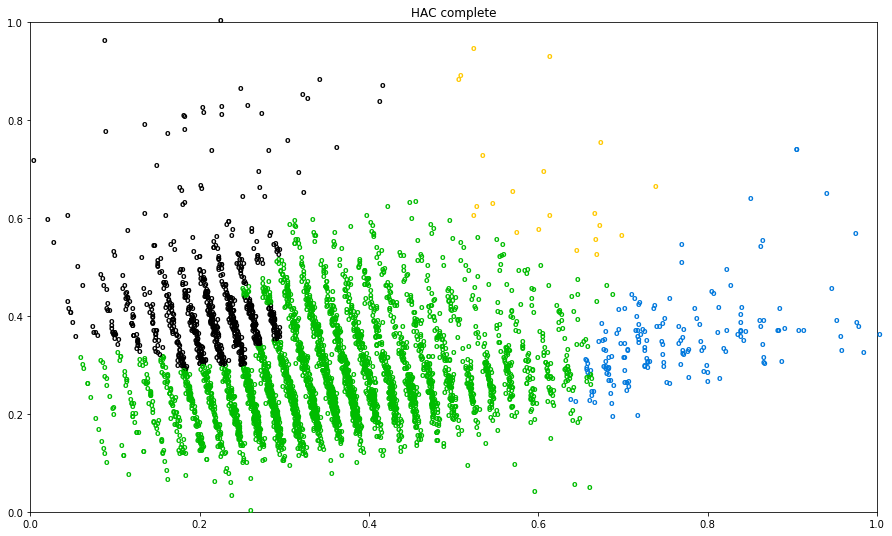

In [11]:
#Visualización 2D
from sklearn.cluster import AgglomerativeClustering as hac
hac = hac(linkage="complete", n_clusters=4, affinity="euclidean")
hac.fit(beer_red)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
	plt.text(beer_red[i,0], beer_red[i,1], 'o',
	color=plt.cm.spectral(hac.labels_[i]/4.),
	fontdict={'weight': 'bold', 'size': 8})

plt.title("HAC complete")
plt.show()


**Ward** :
Ward es una variante de HAC, en cada etapa, se unen los dos clusters
para los cuales se tenga el menor incremento en el valor total de la suma de los cuadrados de las diferencias,
dentro de cada cluster, de cada individuo al centroide del cluster.

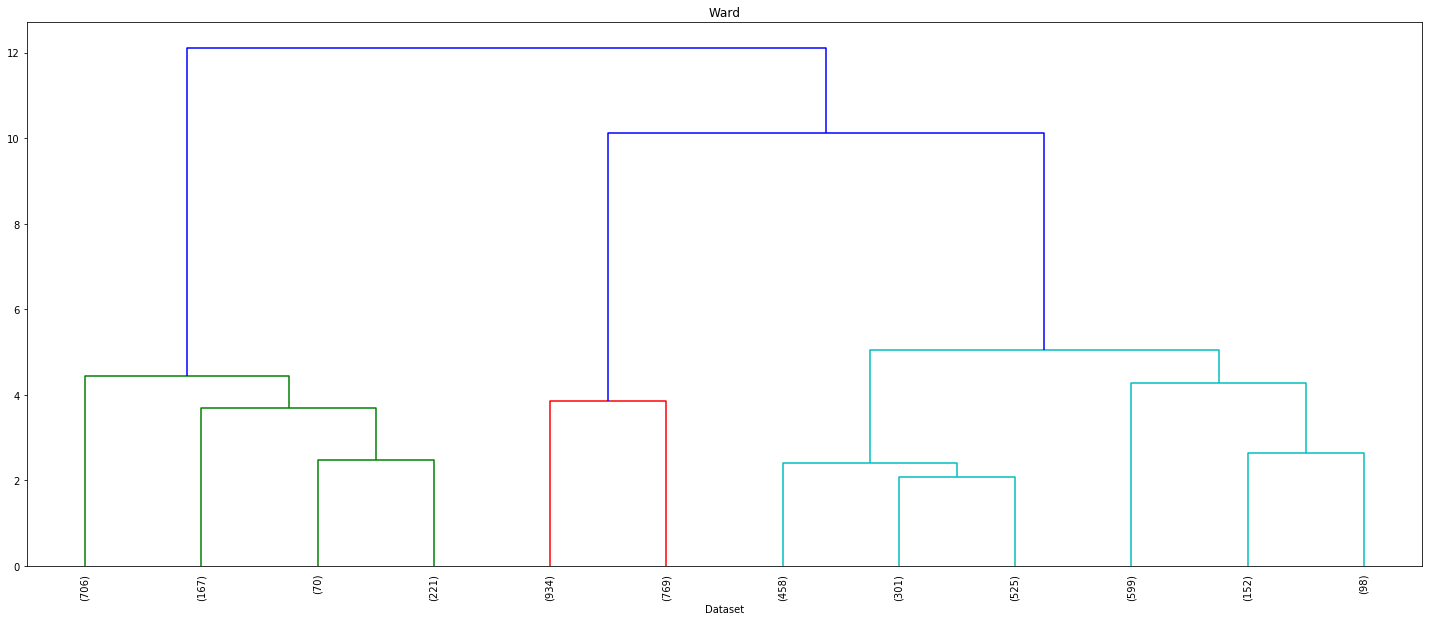

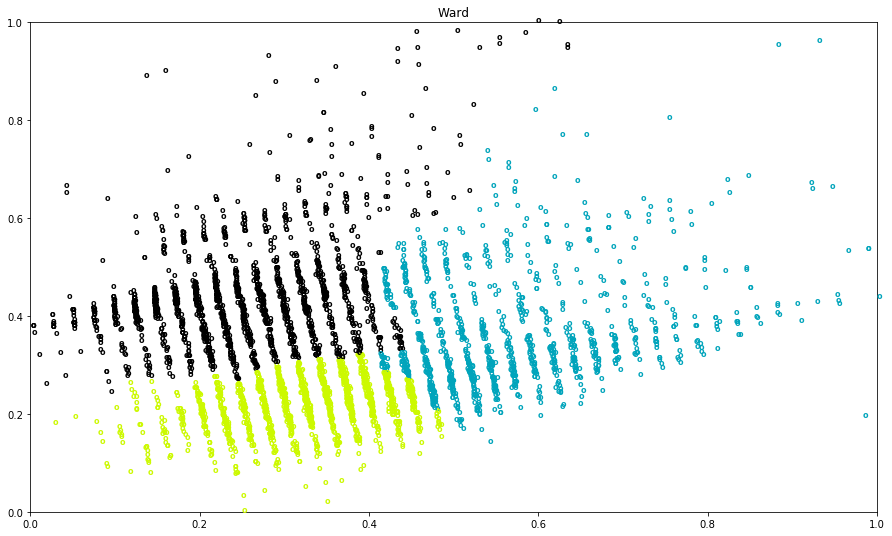

In [6]:
from scipy.cluster.hierarchy import dendrogram,linkage
#matplotlib inline np.set_printoptions(precision=5, suppress=True)
#plt.scatter(beer_red[:,0], beer_red[:,1])
#plt.show()
Z = linkage(beer_red,'ward')
#Visualización en dendrograma
plt.figure(figsize=(25, 10))
plt.title('Ward')
plt.xlabel('Dataset')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12,
    leaf_rotation=90.,  
    leaf_font_size=10., 
)
plt.show()

#Visualización en 2D:
from sklearn.cluster import AgglomerativeClustering as hac
hac = hac(linkage="ward", n_clusters=3, affinity="euclidean")
hac.fit(beer_red)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for i in range(n_samples):
	plt.text(beer_red[i,0], beer_red[i,1], 'o',
	color=plt.cm.spectral(hac.labels_[i]/3.),
	fontdict={'weight': 'bold', 'size': 8})
plt.title("Ward")
plt.show()


**DBSCAN** Es un método de clustering basado en densidad,los dos parámetros principales es el EPS, es el radio máximo donde cada dato abarca a una cantidad MinPts de vecinos. Este algoritmo es muy sensible a sus parámetros, por ejemplo, si el EPS es muy grande, todos son vecinos de todos.Si EPS es muy pequeño, nadie es vecino de nadie.

/home/fabian/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


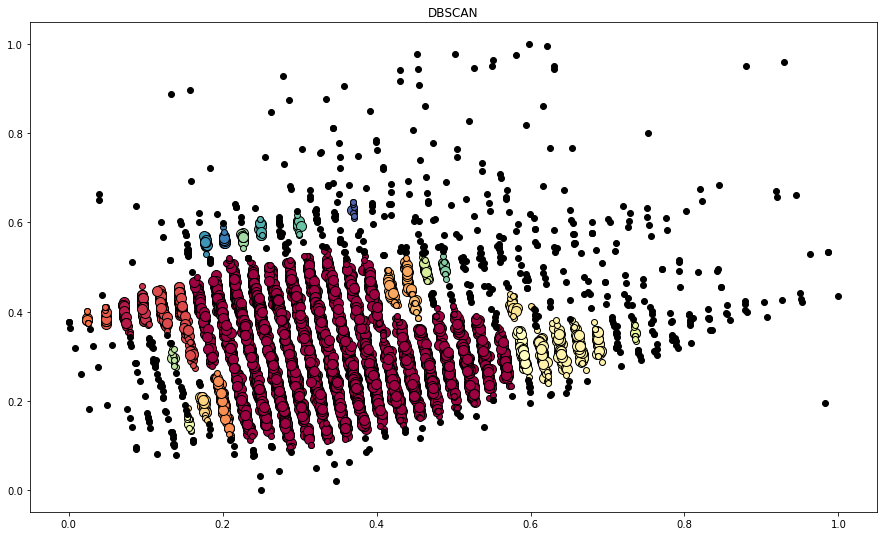

In [17]:
import numpy, scipy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

db = DBSCAN(eps=0.02, min_samples=10).fit(beer_red)
core_samples_mask = numpy.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)
colors = plt.cm.Spectral(numpy.linspace(0, 1, len(unique_labels)))
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0.02, right=1, bottom=0.05, top=0.9)
for k, col in zip(unique_labels, colors):
	if k == -1:
		col = 'k'
	class_member_mask = (labels == k)
	xy = beer_red[class_member_mask & core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
	xy = beer_red[class_member_mask & ~core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
    
plt.title("DBSCAN")
plt.show()

Muestre una visualizacion por cada algoritmo. Realice ajustes a los par ́ametros de cada uno, hasta
que logre obtener una buena soluci ́on. Justifique el procedimiento y elecci ́on de estos par ́ametros.
Comente cada resultado obtenido.



¿Qu ́e atributo, Nombre de cervecer ́ıa o Tipo de cerveza, describe mejor a los cluster como eti-
quetas de clase, seg ́
un los resultados obtenidos previamente? ¿Hay mejores marcas que otras en
relaci ́
on a las evaluaciones obtenidas? ¿Se puede definir alg ́
un criterio para determinar el mejor
tipo de cerveza? Comente.